In [52]:
import numpy as np
import sympy
import cirq
import tensorflow as tf
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt

In [12]:
qubits = cirq.GridQubit.rect(1, 3)
circuit = cirq.Circuit()
symbols=[]
for k in range(2):
    sy=sympy.Symbol(str(k))
    symbols.append(str(k))
    circuit += cirq.ry(sy)(qubits[k])


In [13]:
circuit

(0, 0): ───Ry(0)───

(0, 1): ───Ry(1)───

In [65]:
ops = tfq.convert_to_tensor([[cirq.Z(qubits[0]), cirq.Z(qubits[1])]])

In [66]:
circuit_inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
expectation = tfq.layers.Expectation()(
        circuit_inputs,
        symbol_names = symbols,
        operators = ops
        )

In [67]:
model = tf.keras.Model(inputs = circuit_inputs, outputs=expectation)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=tf.keras.losses.mean_squared_error)

In [68]:
model(tfq.convert_to_tensor([circuit]))

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-0.99845946,  0.18441586]], dtype=float32)>

In [69]:
desired_outputs = tf.ones((1,2))*.5

In [70]:
@tf.function
def step():
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        preds = model(tfq.convert_to_tensor([circuit]))
        loss = model.loss(desired_outputs, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss
    
#@tf.function
def step1():
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        preds = model(tfq.convert_to_tensor([circuit]))
        loss = model.loss(desired_outputs, preds)
        grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        return loss

In [61]:
%timeit step()

859 µs ± 192 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [62]:
%timeit step1()

6.07 ms ± 195 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
ll = []
for k in range(1000):
    ll.append(step().numpy()[0])

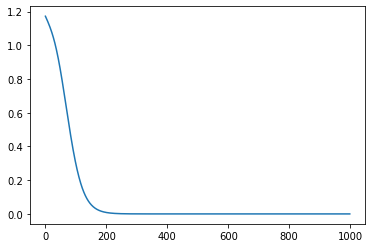

In [72]:
plt.plot(ll)

In [78]:
resolver = {k: v for k, v in zip(symbols, model.get_weights()[0])}
simulator = cirq.Simulator()
simulator.simulate(cirq.resolve_parameters(circuit,resolver))

measurements: (no measurements)
output vector: 0.75|00⟩ + 0.433|01⟩ + 0.433|10⟩ + 0.25|11⟩

In [82]:
la = tfq.convert_to_tensor([cirq.resolve_parameters(circuit,resolver)])
tfq.layers.Expectation()(la, operators= ops)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.4999991, 0.5000001]], dtype=float32)>